# Edge Detectors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

### Loading in Test Images

In [2]:
RGB_img = Image.open('./Images/Rocket_Image.jpg')
Grayscale_Img = RGB_img.convert('L')

## 1) Laplacian Edge Detector

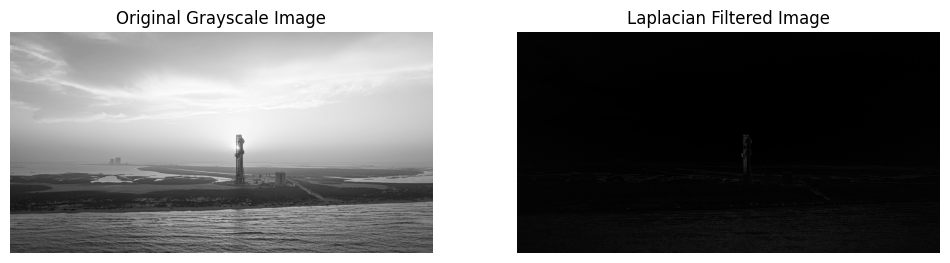

In [3]:
# 1. Creating the mask to implement Laplacian Filter
laplacian_mask = np.array([[0, 1, 0],
                            [1, -4, 1],
                            [0, 1, 0]])

# 2. Apply Convolution
grayscale_array = np.array(Grayscale_Img)
laplacian_grayscale_img = cv2.filter2D(grayscale_array, -1, laplacian_mask)

# Compare the images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Grayscale Image")
plt.imshow(grayscale_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Laplacian Filtered Image")
plt.imshow(laplacian_grayscale_img, cmap='gray')
plt.axis('off')

plt.show()


## 2) Sobel Edge Detector 

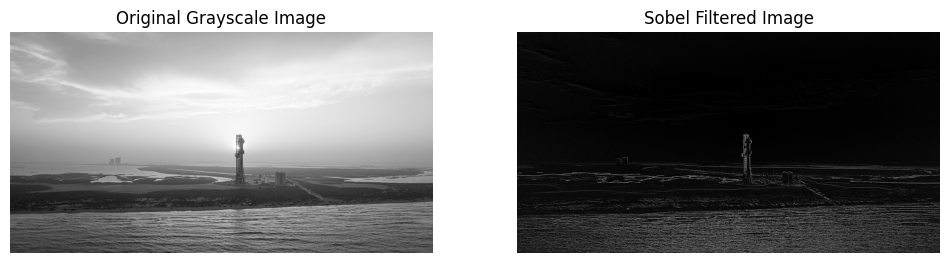

In [4]:
# Create the Sobel Filter Masks
Sobel_X = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

Sobel_Y = np.array([[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]])
# Apply Sobel Filter
sobel_x_img = cv2.filter2D(grayscale_array, -1, Sobel_X)
sobel_y_img = cv2.filter2D(grayscale_array, -1, Sobel_Y)

# Combine the results
sobel_combined = np.hypot(sobel_x_img, sobel_y_img)
sobel_combined = np.uint8(sobel_combined)

# Compare the images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Grayscale Image")
plt.imshow(grayscale_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Sobel Filtered Image")
plt.imshow(sobel_combined, cmap='gray')
plt.axis('off')

plt.show()


## 3) Canny Edge Detector

In [5]:
# 1. Noise reduction using gaussian blur (5x5 kernel)
def gaussian_kernel(size=5, sigma=1):
    ax = np.linspace(-(size-1)//2, (size-1)//2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

def convolve(img, kernel):
    k = kernel.shape[0] // 2
    padded = np.pad(img, ((k, k), (k, k)), mode='edge')
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.sum(region * kernel)
    return result

blurred = convolve(grayscale_array, gaussian_kernel(5, 1))

In [6]:
# 2. Gradient calculation (Sobel filters)
Kx = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]])
Ky = np.array([[-1, -2, -1],
               [ 0,  0,  0],
               [ 1,  2,  1]])

Ix = convolve(blurred, Kx)
Iy = convolve(blurred, Ky)

magnitude = np.hypot(Ix, Iy)
magnitude = magnitude / magnitude.max() * 255
theta = np.arctan2(Iy, Ix)

In [7]:
# 3. Non-maximum suppression
def non_max_suppression(mag, theta):
    Z = np.zeros_like(mag)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, mag.shape[0]-1):
        for j in range(1, mag.shape[1]-1):
            q = 255
            r = 255
            # angle 0
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = mag[i, j+1]
                r = mag[i, j-1]
            # angle 45
            elif (22.5 <= angle[i,j] < 67.5):
                q = mag[i+1, j-1]
                r = mag[i-1, j+1]
            # angle 90
            elif (67.5 <= angle[i,j] < 112.5):
                q = mag[i+1, j]
                r = mag[i-1, j]
            # angle 135
            elif (112.5 <= angle[i,j] < 157.5):
                q = mag[i-1, j-1]
                r = mag[i+1, j+1]

            if (mag[i,j] >= q) and (mag[i,j] >= r):
                Z[i,j] = mag[i,j]
            else:
                Z[i,j] = 0
    return Z

non_max_suppression = non_max_suppression(magnitude, theta)


In [8]:
# 4. Double threshold + hysteresis
def threshold(img, low, high):
    strong = 255
    weak = 75

    res = np.zeros_like(img, dtype=np.uint8)

    strong_i, strong_j = np.where(img >= high)
    weak_i, weak_j = np.where((img <= high) & (img >= low))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    return res, weak, strong

def hysteresis(img, weak, strong):
    strong_i, strong_j = np.where(img == strong)
    for i, j in zip(strong_i, strong_j):
        # Check 8-connected neighbors
        for x in range(-1, 2):
            for y in range(-1, 2):
                if (0 <= i+x < img.shape[0]) and (0 <= j+y < img.shape[1]):
                    if img[i+x, j+y] == weak:
                        img[i+x, j+y] = strong
    return img


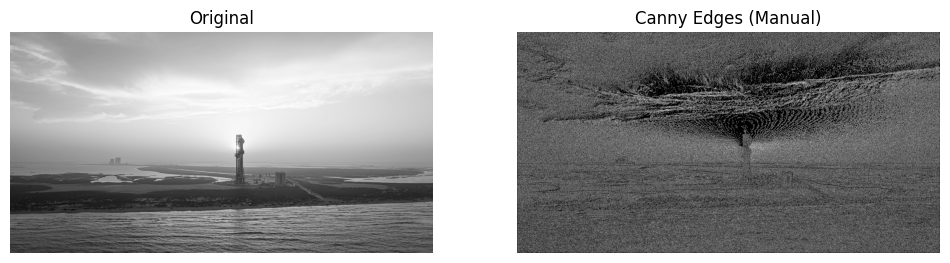

In [9]:
double_threshold, weak, strong = threshold(non_max_suppression, 50, 100)
final_edges = hysteresis(double_threshold, weak, strong)

# Show result and compare with original image
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(grayscale_array, cmap='gray')
plt.axis('off')
plt.title("Original")

plt.subplot(1,2,2) 
plt.imshow(final_edges, cmap='gray')
plt.title("Canny Edges (Manual)")
plt.axis('off')
plt.show()


## 4) Laplacian of Gaussian(LoG) Edge Detector

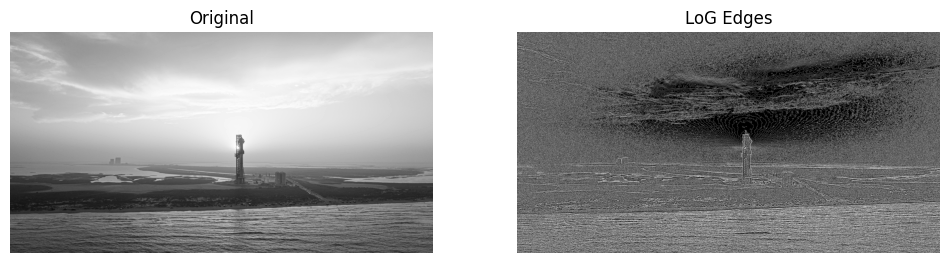

In [13]:
from scipy.ndimage import gaussian_filter, laplace

# 2. Apply Gaussian Blur
blurred = gaussian_filter(grayscale_array, sigma=1.0)  # sigma controls smoothing

# 3. Apply Laplacian
log_img = laplace(blurred)

# 4. Take absolute + normalize to [0,255]
log_img = np.abs(log_img)
log_img = (log_img / log_img.max()) * 255
log_img = log_img.astype(np.uint8)

# Convert back to image
edge_img = Image.fromarray(log_img)

# Show results
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(grayscale_array, cmap="gray")
plt.title("Original")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(edge_img, cmap="gray")
plt.title("LoG Edges")
plt.axis('off')
plt.show()
